# AI Trading Platform - Tweets Sentiment Analysis (AAPL - case study) 

In this notebook we are going to make a **sentiment analysis** for tweets using Vader and a pretrained Transformer based model (RoberTa). The objective is to acquire sentiment scores that would then be used in training the model for stock predictions.

First of all importing our libraries 


In [96]:
!pip install opendatasets --upgrade --quiet
!pip install transformers
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import Word2Vec
import time
from gensim.utils import simple_preprocess
from tqdm.notebook import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline

# setting a plot style 
plt.style.use('ggplot')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Our Test Dataset Sentiment140 ( from Stanford )

downloading our dataset - Sentiment140 dataset with 1.6 million tweets - from Kaggle. Note that you need to provide your Kaggle credentials which you can find in the Kaggle API Token

In [97]:
od.download("https://www.kaggle.com/datasets/kazanova/sentiment140/")

Skipping, found downloaded files in "./sentiment140" (use force=True to force download)


- This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive).
- Now that we have our data downloaded lets take a look at it!

In [98]:
# set dataset column names
columns = ['target','ids','date','query','user','text']

tweets_df = pd.read_csv('/content/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=columns)

print("Our dataset has ",tweets_df.shape[0]," records and ",tweets_df.shape[1]," columns." )
tweets_df.head()

Our dataset has  1600000  records and  6  columns.


,target,ids,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [99]:
# Postive review is marked as 4, changing it to 1.
# Negative review is marked as 0, changing it to -1.

tweets_df['target'] = tweets_df['target'].replace(4,1)
tweets_df['target'] = tweets_df['target'].replace(0,-1)
tweets_df.head()

,target,ids,date,query,user,text
0,-1,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,-1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,-1,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,-1,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,-1,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


we are only interested in the target, ids and text so we will drop the other columns

In [100]:
tweets_df = tweets_df[["target", "ids","text"]]
tweets_df.head()

,target,ids,text
0,-1,1467810369,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,-1,1467810672,is upset that he can't update his Facebook by ...
2,-1,1467810917,@Kenichan I dived many times for the ball. Man...
3,-1,1467811184,my whole body feels itchy and like its on fire
4,-1,1467811193,"@nationwideclass no, it's not behaving at all...."


In [101]:
# selecting a subset of tweets and maintaining the correct target ratio!!
# we could use the whole dataset this is just to save time 

pos = tweets_df[tweets_df['target'] == 1]
neg = tweets_df[tweets_df['target'] == -1]

pos_df = pos.iloc[:int(500)]
neg_df = neg.iloc[:int(500)]

tweets_df = pd.concat([pos_df, neg_df])

pos_log_reg = pos.iloc[:int(50000)]
neg_log_reg = neg.iloc[:int(50000)]
tweets_df_log_reg = pd.concat([pos_log_reg, neg_log_reg])


# Machine Learning

## A Quick EDA

In [102]:
# check for null values
tweets_df_log_reg.isnull().sum()

target    0
ids       0
text      0
dtype: int64

we have no null values. Now lets check for bias 

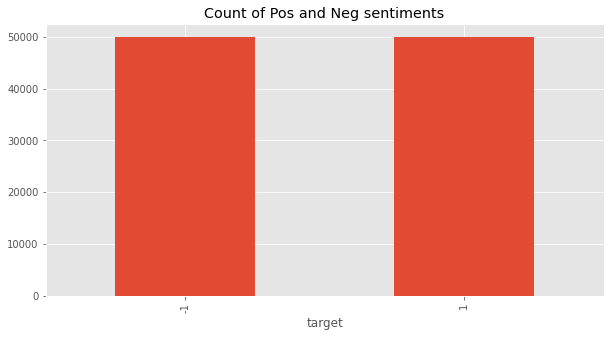

In [103]:
ax = tweets_df_log_reg['target'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Pos and Neg sentiments',
          figsize=(10, 5))
ax.set_xlabel('target')
plt.show()

Our dataset is 50% negative 50% positive so it is a good dataset for training our logistic regression model   

## Text Data Preprocessing

In [104]:
# convert to lower case 
tweets_df_log_reg['text'] = tweets_df_log_reg['text'].str.lower()
tweets_df_log_reg.head()

,target,ids,text
800000,1,1467822272,i love @health4uandpets u guys r the best!!
800001,1,1467822273,im meeting up with one of my besties tonight! ...
800002,1,1467822283,"@darealsunisakim thanks for the twitter add, s..."
800003,1,1467822287,being sick can be really cheap when it hurts t...
800004,1,1467822293,@lovesbrooklyn2 he has that effect on everyone


stop words occur in abundance, hence providing little to no unique information that can be used for classification so we need to remove these. 

In [105]:
#Setting English stopwords
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

#Removing the stopwords
def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# remove links, and mentions and non-letters
def cleaning(text):
    text = re.sub('((www.[^s]+)|(https?://[^s]+))',' ',text)
    text = re.sub(r'@\w+',' ', text)
    text = re.sub('[^a-zA-Z#]',' ',text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [106]:
nltk.download('punkt')

tweets_df_log_reg['text'] = tweets_df_log_reg['text'].apply(lambda x: cleaning(x))
tweets_df_log_reg['text'] = tweets_df_log_reg['text'].apply(remove_stopwords)

tweets_df_log_reg.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,target,ids,text
800000,1,1467822272,love u guys r best
800001,1,1467822273,im meeting one besties tonight cant wait girl ...
800002,1,1467822283,thanks twitter add sunisa got meet hin show dc...
800003,1,1467822287,sick really cheap hurts much eat real food plu...
800004,1,1467822293,effect everyone


### word cloud for positive sentiment

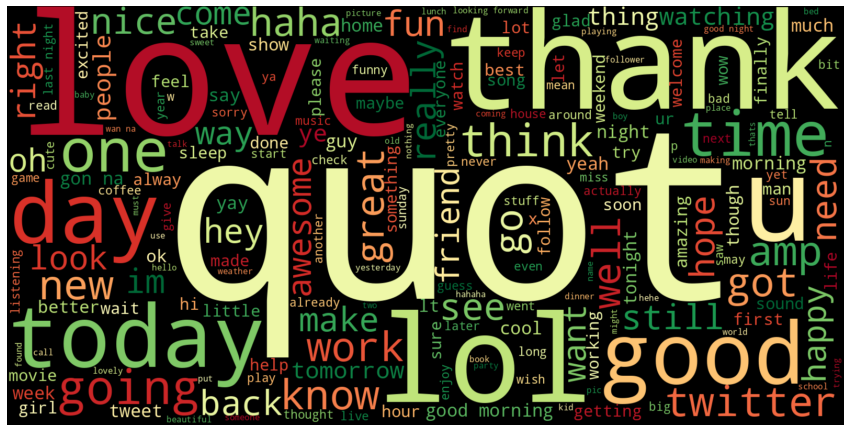

In [107]:
words = " ".join([sentence for sentence in tweets_df_log_reg['text'][tweets_df_log_reg['target']==1]])

wordcloud = WordCloud(colormap='RdYlGn',width=1600, height=800, random_state=42).generate(words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### word cloud for negative sentiment

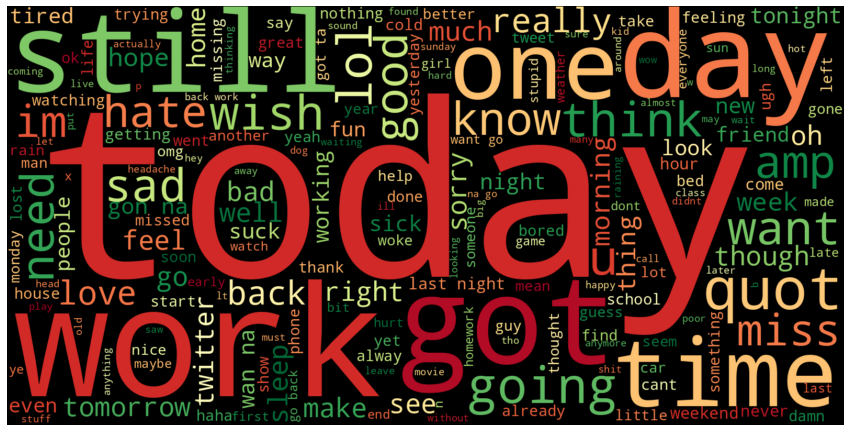

In [108]:
words = " ".join([sentence for sentence in tweets_df_log_reg['text'][tweets_df_log_reg['target']==-1]])

wordcloud = WordCloud(colormap='RdYlGn',width=1600, height=800, random_state=42).generate(words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Tokenization

In [109]:
# Tokenize the text column to get the new column 'tokenized_text'
tweets_df_log_reg['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in tweets_df_log_reg['text']] 
print(tweets_df_log_reg['tokenized_text'].head(10))

800000                                   [love, guys, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [thanks, twitter, add, sunisa, got, meet, hin,...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                                   [effect, everyone]
800005    [tell, burst, laughing, really, loud, thanks, ...
800006       [thans, response, ihad, already, find, answer]
800007    [jealous, hope, great, time, vegas, like, acm,...
800008    [ah, congrats, mr, fletcher, finally, joining,...
800009    [responded, stupid, cat, helping, type, forgiv...
Name: tokenized_text, dtype: object


Now we know that having multiple inflected forms inside the same text adds redundancy to the NLP process.

As a result, we employ stemming and lemmatization to reduce words to their basic form or stem/lemma.

In [110]:
nltk.download('wordnet')
nltk.download('omw-1.4')

stemmer = nltk.PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return text

lm = nltk.WordNetLemmatizer()
def lemmatizing(data):
    text = [lm.lemmatize(word) for word in data]
    return text



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [111]:
tweets_df_log_reg['tokenized_text']= tweets_df_log_reg['tokenized_text'].apply(lambda x: stemming(x))
tweets_df_log_reg['tokenized_text'] = tweets_df_log_reg['tokenized_text'].apply(lambda x: lemmatizing(x))
tweets_df_log_reg.head()

,target,ids,text,tokenized_text
800000,1,1467822272,love u guys r best,"[love, guy, best]"
800001,1,1467822273,im meeting one besties tonight cant wait girl ...,"[im, meet, one, besti, tonight, cant, wait, gi..."
800002,1,1467822283,thanks twitter add sunisa got meet hin show dc...,"[thank, twitter, add, sunisa, got, meet, hin, ..."
800003,1,1467822287,sick really cheap hurts much eat real food plu...,"[sick, realli, cheap, hurt, much, eat, real, f..."
800004,1,1467822293,effect everyone,"[effect, everyon]"


## Data preparation

In [112]:
# Input and Label
X = tweets_df_log_reg.tokenized_text
y = tweets_df_log_reg.target

In [113]:
# Train and Test (It is important to balance classes --> shuffle) 
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.25, shuffle=True, random_state = 42)
print("Value counts for Train sentiments")
print(y_train.value_counts())
print("Value counts for Test sentiments")
print(y_test.value_counts())
X_train = X_train.to_frame().reset_index()
X_test = X_test.to_frame().reset_index()
y_train = y_train.to_frame().reset_index()
y_test = y_test.to_frame().reset_index()


Value counts for Train sentiments
-1    37528
 1    37472
Name: target, dtype: int64
Value counts for Test sentiments
 1    12528
-1    12472
Name: target, dtype: int64


## Text Vectorization

Words are more than just a collection of letters. As speakers of a language, we might understand what a word means and how to use it in a sentence. In short, we would understand its semantics. The sparse, count-based methods we saw above do not account for the meaning of the words or phrases that our system processes.

In 2013, a team led by NLP researcher Tomáš Mikolov came up with the Word2Vec method, which could represent the semantic and syntactic properties of words through “word embeddings.”

## Word2Vec

In the high-dimensional Word2Vec embedding space, similar words lie close to each other.

In [114]:
# default values
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1 # Skip-gram model 

word2vec_model_file = '/content/models/' + 'word2vec_' + str(size) + '.model'
start_time = time.time()
tokens = pd.Series(tweets_df_log_reg['tokenized_text']).values

# Train the Word2Vec Model
w2v_model = Word2Vec(tokens, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 69.951908826828


In [115]:
# Load the model from the model file
sg_w2v_model = Word2Vec.load(word2vec_model_file)

# Unique ID of the word
print("Index of the word 'love':")
print(sg_w2v_model.wv.vocab["love"].index)

# Total number of the words 
print(len(sg_w2v_model.wv.vocab))

# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(sg_w2v_model['love']))

# Get the mean for the vectors for an example review
print("Print the length after taking average of all word vectors in a sentence:")
print(len(np.mean([sg_w2v_model[token] for token in tweets_df_log_reg['tokenized_text'][0]], axis=0)))


Index of the word 'love':
6
38913
Length of the vector generated for a word
1000
Print the length after taking average of all word vectors in a sentence:
1000


<ipython-input-115-a91fd89d45ca>:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(len(sg_w2v_model['love']))
<ipython-input-115-a91fd89d45ca>:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(len(np.mean([sg_w2v_model[token] for token in tweets_df_log_reg['tokenized_text'][0]], axis=0)))


Word2Vec vectors are generated for each review in train data by traversing through the X_train dataset. By simply using the model on each word of the review, we get the word embedding vectors for those words. We will be implementing average over all the vectors of words in a sentence and that will represent a sentence from our dataset. These vectors are stored in a csv file. You can directly create this in a dataframe but when there is a large amount of data it is better to write to a file as and when the vector is created and if the code breaks you can start from the point where it had broken.

In [116]:
word2vec_filename = '/content/models/' + 'train_tweets_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        model_vector = (np.mean([sg_w2v_model[token] for token in row['tokenized_text']], axis=0)).tolist()

        # write header
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")

        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
            
        word2vec_file.write(line1)
        word2vec_file.write('\n')

<ipython-input-116-7e2ec103ddb4>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model_vector = (np.mean([sg_w2v_model[token] for token in row['tokenized_text']], axis=0)).tolist()
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Logistic Regression


In [117]:
# Load from the filename
word2vec_df = pd.read_csv(word2vec_filename)
#Initialize the model
clf_log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)

start_time = time.time()
# Fit the model
clf_log_reg.fit(word2vec_df, y_train['target'])
print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the model with word2vec vectors: 55.77777290344238


Now we need to test our model

In [118]:
test_features_word2vec = []
for index, row in X_test.iterrows():
    model_vector = np.mean([sg_w2v_model[token] for token in row['tokenized_text']], axis=0).tolist()
    if type(model_vector) is list:
        test_features_word2vec.append(model_vector)
    else:
        test_features_word2vec.append(np.array([0 for i in range(1000)]))
test_predictions_word2vec = clf_log_reg.predict(test_features_word2vec)
print("The Classification Report: ")
print(classification_report(y_test['target'],test_predictions_word2vec))
print("Accuracy: ")
print(accuracy_score(y_test['target'], test_predictions_word2vec))

<ipython-input-118-aa49719b5490>:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model_vector = np.mean([sg_w2v_model[token] for token in row['tokenized_text']], axis=0).tolist()
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


The Classification Report: 
              precision    recall  f1-score   support

          -1       0.70      0.69      0.70     12472
           1       0.70      0.71      0.70     12528

    accuracy                           0.70     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.70      0.70      0.70     25000

Accuracy: 
0.6996


Now we could try VADER( Valence Aware Dictionary for Sentiment Reasoning); it is an NLTK module that provides sentiment scores based on the words used. It is a rule-based sentiment analyzer in which the terms are generally labeled as per their semantic orientation as either positive or negative.

# VADER( Valence Aware Dictionary for Sentiment Reasoning)

In [119]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [120]:
sia.polarity_scores("Wow, NLTK is really powerful!")

{'neg': 0.0, 'neu': 0.295, 'pos': 0.705, 'compound': 0.8012}

In [121]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [122]:
def vader (data_frame):
  nltk.download('vader_lexicon')
  sia = SentimentIntensityAnalyzer()
  res = {}
  for index, row in tqdm(data_frame.iterrows(), total=len(data_frame)):
    text = row['text']
    id =row['ids']
    score = sia.polarity_scores(text)
    #positive
    if score['compound'] >= 0.05 :
        sentiment = 1
    #negative
    elif score['compound'] <= - 0.05 :
        sentiment = -1
    #neutral
    else :
        sentiment = 0
    score['sentiment']=sentiment
    res[id]=score

  return res


In [123]:
def get_vader_sentiment(data_frame):
  vader_result = vader(data_frame)
  vaders = pd.DataFrame(vader_result).T
  vaders.reset_index(inplace=True)
  vaders.columns=['ids','neg','neu','pos','compound','vader_sentiment']
  vaders = vaders.merge(data_frame,how='left')
  return vaders

In [124]:
def get_vader_classification_report (data_frame):
  print("The Classification Report: ")
  print(classification_report(data_frame['target'],data_frame['vader_sentiment']))
  print("Accuracy: ")
  print(accuracy_score(data_frame['target'], data_frame['vader_sentiment']))

In [125]:
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
        
tweets_df['text'] = tweets_df['text'].apply(remove_mentions)
vader_df = get_vader_sentiment(tweets_df)
vader_df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  0%|          | 0/1000 [00:00<?, ?it/s]

,ids,neg,neu,pos,compound,vader_sentiment,target,text
0,1467822272,0.000,0.171,0.829,0.8938,1.0,1,I LOVE u guys r the best!!
1,1467822273,0.000,1.000,0.000,0.0000,0.0,1,im meeting up with one of my besties tonight! ...
2,1467822283,0.000,0.737,0.263,0.8172,1.0,1,"Thanks for the Twitter add, Sunisa! I got to ..."
3,1467822287,0.233,0.655,0.113,-0.5106,-1.0,1,Being sick can be really cheap when it hurts t...
4,1467822293,0.000,1.000,0.000,0.0000,0.0,1,he has that effect on everyone


In [126]:
get_vader_classification_report(vader_df)

The Classification Report: 
              precision    recall  f1-score   support

        -1.0       0.80      0.47      0.59       500
         0.0       0.00      0.00      0.00         0
         1.0       0.67      0.58      0.62       500

    accuracy                           0.53      1000
   macro avg       0.49      0.35      0.40      1000
weighted avg       0.73      0.53      0.61      1000

Accuracy: 
0.525


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see that the accuracy of Vader is less than that of logistic regression now we are going to test the pretrained transformer based model  

# distilbert Pretrained Model

In [127]:
classifier = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")

In [128]:
classifier('We are very happy to show you the 🤗 Transformers library.')


[{'label': 'POSITIVE', 'score': 0.9997795224189758}]

In [129]:
def distilbert(data_frame):
  classifier = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english")
  res = {}
  for index, row in tqdm(data_frame.iterrows(), total=len(data_frame)):
    text = row['text']
    id =row['ids']
    score = classifier(text)
    #positive
    if score[0]['label'] == 'POSITIVE' :
        sentiment = 1
    #negative
    elif score[0]['label'] == 'NEGATIVE' :
        sentiment = -1
    #neutral
    else :
        sentiment = 0
    score[0]['sentiment']=sentiment
    res[id]=score[0]

  return res

In [130]:
def get_bert_sentiment(data_frame):
  bert_result = distilbert(data_frame)
  bert = pd.DataFrame(bert_result).T
  bert.reset_index(inplace=True)
  bert.columns=['ids','label','score','bert_sentiment']
  bert = bert.merge(tweets_df,how='left')
  bert['bert_sentiment'] = bert['bert_sentiment'].astype(float)
  return bert

In [131]:
def get_bert_classification_report (data_frame):
  print("The Classification Report: ")
  print(classification_report(data_frame['target'],data_frame['bert_sentiment']))
  print("Accuracy: ")
  print(accuracy_score(data_frame['target'], data_frame['bert_sentiment']))

In [132]:
bert_df = get_bert_sentiment(tweets_df)
bert_df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,ids,label,score,bert_sentiment,target,text
0,1467822272,POSITIVE,0.999854,1.0,1,I LOVE u guys r the best!!
1,1467822273,POSITIVE,0.906398,1.0,1,im meeting up with one of my besties tonight! ...
2,1467822283,POSITIVE,0.99981,1.0,1,"Thanks for the Twitter add, Sunisa! I got to ..."
3,1467822287,NEGATIVE,0.998503,-1.0,1,Being sick can be really cheap when it hurts t...
4,1467822293,POSITIVE,0.999631,1.0,1,he has that effect on everyone


In [133]:
get_bert_classification_report(bert_df)

The Classification Report: 
              precision    recall  f1-score   support

          -1       0.68      0.82      0.74       500
           1       0.77      0.61      0.68       500

    accuracy                           0.72      1000
   macro avg       0.73      0.72      0.71      1000
weighted avg       0.73      0.72      0.71      1000

Accuracy: 
0.716


Now let's try a model trained on tweets 

# Roberta Pretrained Model

In [134]:
classifier = pipeline('sentiment-analysis', model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [135]:
classifier('We are very happy to show you the 🤗 Transformers library.')


[{'label': 'positive', 'score': 0.985775887966156}]

In [136]:
def roberta(data_frame):
  classifier = pipeline('sentiment-analysis', model="cardiffnlp/twitter-roberta-base-sentiment-latest")
  res = {}
  for index, row in tqdm(data_frame.iterrows(), total=len(data_frame)):
    text = row['text']
    id =row['ids']
    score = classifier(text)
    #positive
    if score[0]['label'] == 'positive' :
        sentiment = 1
    #negative
    elif score[0]['label'] == 'negative' :
        sentiment = -1
    #neutral
    else :
        sentiment = 0
    score[0]['sentiment']=sentiment
    res[id]=score[0]

  return res

In [137]:
def get_roberta_sentiment(data_frame):
  roberta_result = roberta(data_frame)
  roberta_df = pd.DataFrame(roberta_result).T
  roberta_df.reset_index(inplace=True)
  roberta_df.columns=['ids','label','score','roberta_sentiment']
  roberta_df = roberta_df.merge(data_frame,how='left')
  roberta_df['roberta_sentiment'] = roberta_df['roberta_sentiment'].astype(float)
  return roberta_df

In [138]:
def get_roberta_classification_report (data_frame):
  print("The Classification Report: ")
  print(classification_report(data_frame['target'],data_frame['roberta_sentiment']))
  print("Accuracy: ")
  print(accuracy_score(data_frame['target'], data_frame['roberta_sentiment']))

In [139]:
roberta_df = get_roberta_sentiment(tweets_df)
roberta_df.head()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1000 [00:00<?, ?it/s]

,ids,label,score,roberta_sentiment,target,text
0,1467822272,positive,0.989069,1.0,1,I LOVE u guys r the best!!
1,1467822273,positive,0.992582,1.0,1,im meeting up with one of my besties tonight! ...
2,1467822283,positive,0.981891,1.0,1,"Thanks for the Twitter add, Sunisa! I got to ..."
3,1467822287,negative,0.724771,-1.0,1,Being sick can be really cheap when it hurts t...
4,1467822293,neutral,0.606102,0.0,1,he has that effect on everyone


In [140]:
get_roberta_classification_report(roberta_df)

The Classification Report: 
              precision    recall  f1-score   support

        -1.0       0.90      0.62      0.73       500
         0.0       0.00      0.00      0.00         0
         1.0       0.81      0.61      0.70       500

    accuracy                           0.62      1000
   macro avg       0.57      0.41      0.48      1000
weighted avg       0.85      0.62      0.72      1000

Accuracy: 
0.616


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TWITTER Airline Dataset

In [141]:
od.download("https://www.kaggle.com/crowdflower/twitter-airline-sentiment/download")

Skipping, found downloaded files in "./twitter-airline-sentiment" (use force=True to force download)


In [142]:
#reading the dataframe
airline_df=pd.read_csv('/content/twitter-airline-sentiment/Tweets.csv')
airline_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


We just need the id,sentiment and text

In [143]:
# positive sentiments to 1 and negative to -1 and neutral to 0 
def partition(x):
    if x =='positive':
        return 1
    elif x == 'negative':
        return -1
    return 0

airline_df['airline_sentiment'] = airline_df['airline_sentiment'].map(partition)
airline_df['airline_sentiment'].value_counts() 


-1    9178
 0    3099
 1    2363
Name: airline_sentiment, dtype: int64

In [144]:
# drop the not needed columns 
airline_df = airline_df[["tweet_id", "airline_sentiment","text"]]
airline_df.reset_index(inplace=True,drop=True)
airline_df.head()

,tweet_id,airline_sentiment,text
0,570306133677760513,0,@VirginAmerica What @dhepburn said.
1,570301130888122368,1,@VirginAmerica plus you've added commercials t...
2,570301083672813571,0,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,-1,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,-1,@VirginAmerica and it's a really big bad thing...


In [145]:
airline_df.columns = ['ids','target','text']
airline_df.head()

,ids,target,text
0,570306133677760513,0,@VirginAmerica What @dhepburn said.
1,570301130888122368,1,@VirginAmerica plus you've added commercials t...
2,570301083672813571,0,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,-1,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,-1,@VirginAmerica and it's a really big bad thing...


In [146]:
# selecting a subset of 5k tweets and maintaining the correct target ratio!!
# we could use the whole dataset this is just to save time 

pos = airline_df[airline_df['target'] == 1]
neu = airline_df[airline_df['target'] == 0]
neg = airline_df[airline_df['target'] == -1]

pos = pos.iloc[:int(200)]
neu = neu.iloc[:int(100)]
neg = neg.iloc[:int(200)]

airline_df = pd.concat([pos,neu, neg])
airline_df

,ids,target,text
1,570301130888122368,1,@VirginAmerica plus you've added commercials t...
6,570300616901320704,1,"@VirginAmerica yes, nearly every time I fly VX..."
8,570299953286942721,1,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,570295459631263746,1,"@VirginAmerica it was amazing, and arrived an ..."
11,570289724453216256,1,@VirginAmerica I &lt;3 pretty graphics. so muc...
...,...,...,...
536,570291213007491076,-1,@united I am trying to book awards for Septemb...
537,570290993339244547,-1,@united I sure did. I had to drive a total o...
539,570289777184002048,-1,@united See? We were told repeatedly that the ...
540,570289557205327873,-1,@united why no preferred security line anymore...


## Vader


In [147]:
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
        
airline_df['text'] = airline_df['text'].apply(remove_mentions)
vader_df = get_vader_sentiment(airline_df)
vader_df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  0%|          | 0/500 [00:00<?, ?it/s]

,ids,neg,neu,pos,compound,vader_sentiment,target,text
0,570301130888122368,0.000,1.000,0.000,0.0000,0.0,1,plus you've added commercials to the experien...
1,570300616901320704,0.000,0.659,0.341,0.6908,1.0,1,"yes, nearly every time I fly VX this “ear wor..."
2,570299953286942721,0.409,0.347,0.243,-0.3477,-1.0,1,"Well, I didn't…but NOW I DO! :-D"
3,570295459631263746,0.000,0.621,0.379,0.7717,1.0,1,"it was amazing, and arrived an hour early. Yo..."
4,570289724453216256,0.000,0.402,0.598,0.8863,1.0,1,I &lt;3 pretty graphics. so much better than ...


In [148]:
get_vader_classification_report(vader_df)

The Classification Report: 
              precision    recall  f1-score   support

          -1       0.84      0.51      0.63       200
           0       0.40      0.51      0.45       100
           1       0.66      0.84      0.74       200

    accuracy                           0.64       500
   macro avg       0.64      0.62      0.61       500
weighted avg       0.68      0.64      0.64       500

Accuracy: 
0.64


## Bert


In [152]:
bert_df = get_bert_sentiment(airline_df)
bert_df.head()

In [151]:
get_bert_classification_report(bert_df)

## Roberta

In [ ]:
roberta_df = get_roberta_sentiment(airline_df)
roberta_df.head()

In [ ]:
get_roberta_classification_report(roberta_df)

# APPLE DATASET

In [80]:
#reading the dataframe
apple_df=pd.read_csv('/content/apple/Apple-Twitter-Sentiment-DFE.csv',encoding = 'unicode_escape', engine ='python')
apple_df

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...
3881,623499442,True,golden,13,NaN,3,0.7757,Tue Dec 09 22:08:53 +0000 2014,5.420000e+17,#AAPL OR @Apple,5\n3,(Via FC) Apple Is Warming Up To Social Media -...
3882,623499450,True,golden,16,NaN,3,0.6225,Tue Dec 09 22:18:27 +0000 2014,5.420000e+17,#AAPL OR @Apple,3\n1,RT @MMLXIV: there is no avocado emoji may I as...
3883,623499486,True,golden,14,NaN,5,0.9347,Tue Dec 09 23:45:59 +0000 2014,5.420000e+17,#AAPL OR @Apple,5,@marcbulandr I could not agree more. Between @...
3884,623499514,True,golden,13,NaN,1,0.9230,Wed Dec 10 00:48:10 +0000 2014,5.420000e+17,#AAPL OR @Apple,1,My iPhone 5's photos are no longer downloading...


In [81]:
# positive sentiments to 1 and negative to -1 and neutral to 0 
def partition(x):
    if x =='5':
        return 1
    elif x == '1':
        return -1
    elif x=='not_relevant':
        return np.nan 
    return 0

apple_df['sentiment'] = apple_df['sentiment'].map(partition)
apple_df['sentiment'].value_counts()

 0.0    2162
-1.0    1219
 1.0     423
Name: sentiment, dtype: int64

In [82]:
# drop the not needed columns 
apple_df = apple_df[["_unit_id", "sentiment","text"]]
apple_df.reset_index(inplace=True,drop=True)
apple_df

,_unit_id,sentiment,text
0,623495513,0.0,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,0.0,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,0.0,My cat only chews @apple cords. Such an #Apple...
3,623495516,0.0,I agree with @jimcramer that the #IndividualIn...
4,623495517,0.0,Nobody expects the Spanish Inquisition #AAPL
...,...,...,...
3881,623499442,0.0,(Via FC) Apple Is Warming Up To Social Media -...
3882,623499450,0.0,RT @MMLXIV: there is no avocado emoji may I as...
3883,623499486,1.0,@marcbulandr I could not agree more. Between @...
3884,623499514,-1.0,My iPhone 5's photos are no longer downloading...


In [83]:
apple_df = apple_df.dropna()
apple_df.columns = ['ids','target','text']
apple_df

,ids,target,text
0,623495513,0.0,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,0.0,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,0.0,My cat only chews @apple cords. Such an #Apple...
3,623495516,0.0,I agree with @jimcramer that the #IndividualIn...
4,623495517,0.0,Nobody expects the Spanish Inquisition #AAPL
...,...,...,...
3881,623499442,0.0,(Via FC) Apple Is Warming Up To Social Media -...
3882,623499450,0.0,RT @MMLXIV: there is no avocado emoji may I as...
3883,623499486,1.0,@marcbulandr I could not agree more. Between @...
3884,623499514,-1.0,My iPhone 5's photos are no longer downloading...


In [84]:
#apple_df['text']=apple_df['text'].str.decode("utf-8")
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
apple_df['text'] = apple_df['text'].apply(remove_mentions)

<ipython-input-84-38e25ff89786>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df['text'] = apple_df['text'].apply(remove_mentions)


## Vader


In [ ]:
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
        
airline_df['text'] = airline_df['text'].apply(remove_mentions)
vader_df = get_vader_sentiment(airline_df)
vader_df.head()

In [ ]:
get_vader_classification_report(vader_df)

## Bert


In [ ]:
bert_df = get_bert_sentiment(airline_df)
bert_df.head()

In [ ]:
get_bert_classification_report(bert_df)

## Roberta

In [ ]:
roberta_df = get_roberta_sentiment(airline_df)
roberta_df.head()

In [ ]:
get_roberta_classification_report(roberta_df)

# TextBlob

In [87]:
from textblob import TextBlob

In [88]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
      return -1
    elif score == 0:
      return 0
    else:
      return 1

def sentiment_analysis(data_frame):

  data_frame['TextBlob_Subjectivity'] = data_frame['text'].apply(getSubjectivity)
  data_frame['TextBlob_Polarity'] = data_frame['text'].apply(getPolarity)
  data_frame['TextBlob_Analysis'] = data_frame['TextBlob_Polarity'].apply(getAnalysis )
  return data_frame

In [94]:
test = sentiment_analysis(airline_df)
test

,ids,target,text,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis
1,570301130888122368,1,@VirginAmerica plus you've added commercials t...,0.000000,0.000000,0
6,570300616901320704,1,"@VirginAmerica yes, nearly every time I fly VX...",0.766667,0.466667,1
8,570299953286942721,1,"@virginamerica Well, I didn't…but NOW I DO! :-D",1.000000,1.000000,1
9,570295459631263746,1,"@VirginAmerica it was amazing, and arrived an ...",0.600000,0.466667,1
11,570289724453216256,1,@VirginAmerica I &lt;3 pretty graphics. so muc...,0.775000,0.412500,1
...,...,...,...,...,...,...
536,570291213007491076,-1,@united I am trying to book awards for Septemb...,0.500000,0.500000,1
537,570290993339244547,-1,@united I sure did. I had to drive a total o...,0.684722,0.325000,1
539,570289777184002048,-1,@united See? We were told repeatedly that the ...,0.600000,-0.300000,-1
540,570289557205327873,-1,@united why no preferred security line anymore...,0.000000,0.000000,0


In [95]:
test['TextBlob_Analysis'] = test['TextBlob_Analysis'].astype(float)
print("The Classification Report: ")
print(classification_report(test['target'],test['TextBlob_Analysis']))
print("Accuracy: ")
print(accuracy_score(test['target'], test['TextBlob_Analysis']))

The Classification Report: 
              precision    recall  f1-score   support

          -1       0.85      0.37      0.52       200
           0       0.34      0.57      0.43       100
           1       0.65      0.80      0.72       200

    accuracy                           0.58       500
   macro avg       0.61      0.58      0.55       500
weighted avg       0.67      0.58      0.58       500

Accuracy: 
0.582


# Determining sentiment using the AWS SDK for Python (Boto)

In [38]:
!pip -q install boto3

In [44]:
import boto3
import json

comprehend = boto3.client(service_name='comprehend', region_name='us-east-2',aws_access_key_id = 'YOUR_ID', 
                          aws_secret_access_key= 'YOUR_SECRET_KEY')

#text = "It is today "

#print('Calling DetectSentiment')
#print(comprehend.detect_sentiment(Text=text, LanguageCode='en'))
#print('End of DetectSentiment\n')

def comprehend_aws(data_frame):
  comprehend = boto3.client(service_name='comprehend', region_name='us-east-2',aws_access_key_id = 'YOUR_ID', 
                          aws_secret_access_key= 'YOUR_SECRET_KEY')
  res = {}
  for index, row in tqdm(data_frame.iterrows(), total=len(data_frame)):
    text = row['text']
    id =row['ids']
    score = comprehend.detect_sentiment(Text=text, LanguageCode='en')
    #positive
    if score['Sentiment'] == 'POSITIVE' :
        sentiment = 1
    #negative
    elif score['Sentiment'] == 'NEGATIVE' :
        sentiment = -1
    #neutral
    elif score['Sentiment'] == 'NEUTRAL' :
        sentiment = 0
    else :
        sentiment = np.nan
    score['sentiment']=sentiment
    res[id]=score

  return res


In [77]:
def get_aws_result (data_frame):
  aws_result = comprehend_aws(data_frame)
  aws_df = pd.DataFrame(aws_result).T
  aws_df.reset_index(inplace=True)
  aws_df = aws_df[["index", "sentiment"]]
  aws_df.columns = ["ids","aws_sentiment"]
  aws_df = aws_df.merge(data_frame,how='left')
  aws_df['aws_sentiment'] = aws_df['aws_sentiment'].astype(float)
  aws_df = aws_df.dropna()
  aws_df.reset_index()
  return aws_df

In [62]:
def get_aws_classification_report (data_frame):
  print("The Classification Report: ")
  print(classification_report(data_frame['target'],data_frame['aws_sentiment']))
  print("Accuracy: ")
  print(accuracy_score(data_frame['target'], data_frame['aws_sentiment']))

In [45]:
aws_result = comprehend_aws(tweets_df)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [68]:
aws_df = pd.DataFrame(aws_result).T
aws_df.reset_index(inplace=True)
aws_df = aws_df[["index", "sentiment"]]
aws_df.columns = ["ids","aws_sentiment"]
aws_df = aws_df.merge(tweets_df,how='left')
aws_df['aws_sentiment'] = aws_df['aws_sentiment'].astype(float)
aws_df = aws_df.dropna()
aws_df.reset_index()
aws_df

,ids,aws_sentiment,target,text
0,1467822272,1.0,1,I LOVE @Health4UandPets u guys r the best!!
1,1467822273,1.0,1,im meeting up with one of my besties tonight! ...
2,1467822283,1.0,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
4,1467822293,0.0,1,@LovesBrooklyn2 he has that effect on everyone
5,1467822391,1.0,1,@ProductOfFear You can tell him that I just bu...
...,...,...,...,...
995,1467934606,-1.0,-1,@Brodhe geez ur no fun are you
996,1467935121,1.0,-1,I wanna be in a punk rock band again
997,1467935189,-1.0,-1,@jyesmith That's a lot of angst for a Tuesday ...
998,1467935271,-1.0,-1,I'm very glad Britney isn't crazy anymore! Tha...


In [69]:
get_aws_classification_report(aws_df)

The Classification Report: 
              precision    recall  f1-score   support

        -1.0       0.88      0.54      0.67       469
         0.0       0.00      0.00      0.00         0
         1.0       0.80      0.52      0.63       479

    accuracy                           0.53       948
   macro avg       0.56      0.35      0.43       948
weighted avg       0.84      0.53      0.65       948

Accuracy: 
0.5305907172995781


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
aws_result = get_aws_result(airline_df)

  0%|          | 0/500 [00:00<?, ?it/s]

In [79]:
get_aws_classification_report(aws_result)

The Classification Report: 
              precision    recall  f1-score   support

          -1       0.89      0.68      0.77       195
           0       0.53      0.83      0.65       100
           1       0.89      0.84      0.86       198

    accuracy                           0.77       493
   macro avg       0.77      0.78      0.76       493
weighted avg       0.82      0.77      0.78       493

Accuracy: 
0.7748478701825557


In [85]:
aws_apple = get_aws_result(apple_df)

  0%|          | 0/3804 [00:00<?, ?it/s]

In [86]:
get_aws_classification_report(aws_apple)

The Classification Report: 
              precision    recall  f1-score   support

        -1.0       0.84      0.62      0.71      1189
         0.0       0.77      0.88      0.82      2128
         1.0       0.56      0.57      0.57       408

    accuracy                           0.76      3725
   macro avg       0.72      0.69      0.70      3725
weighted avg       0.77      0.76      0.76      3725

Accuracy: 
0.763489932885906
